# Model TCNN Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## import

In [1]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from tcn import TCN, tcn_full_summary

from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos
from my_helpers.data_plots import load_data_pos
from my_helpers.data_plots import get_old_data_pos
from my_helpers.data_plots import load_old_data_pos
from my_helpers.data_plots import PATH_DF_GOUV_FR_OLD
from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

## Definitions

In [6]:
mode_train = False

In [3]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr_tcn"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
nb_period_plot = 15
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

##  Helper functions

In [4]:
# FOR MODEL
"""def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)"""

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [6]:
get_data_pos()
df_feat_fr = load_data_pos()

Must load more last days, 17 days missing
['2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21', '2021-02-22']
2021-02-06: 0 records
2021-02-07: 0 records
2021-02-08: 0 records
2021-02-09: 0 records
2021-02-10: 0 records
2021-02-11: 0 records
2021-02-12: 0 records
2021-02-13: 0 records
2021-02-14: 0 records
2021-02-15: 0 records
2021-02-16: 0 records
2021-02-17: 0 records
2021-02-18: 0 records
2021-02-19: 0 records
2021-02-20: 0 records
2021-02-21: 0 records
2021-02-22: 0 records
0 records downloaded
File C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel\df_meteo_fr_20210226_12_00_08.csv moved!


## Retrieve old data

In [7]:
if not os.path.isfile(PATH_DF_GOUV_FR_OLD):
    get_old_data_pos()
    
df_feat_fr_old = load_old_data_pos()

df_feat_fr_old

date       T_min       T_max      H_min      H_max  pos  \
date                                                                        
2020-03-10  2020-03-10  283.708333  289.736667  70.666667  90.416667    8   
2020-03-11  2020-03-11  285.335000  291.913333  66.183333  91.383333   16   
2020-03-12  2020-03-12  284.048333  290.268333  63.866667  89.883333   33   
2020-03-13  2020-03-13  282.503333  289.148333  56.150000  88.500000   61   
2020-03-14  2020-03-14  282.253333  289.338333  62.116667  88.683333   54   
...                ...         ...         ...        ...        ...  ...   
2020-05-08  2020-05-08  287.051695  296.029661  53.568966  86.327586   15   
2020-05-09  2020-05-09  288.019492  295.305932  60.448276  87.448276   29   
2020-05-10  2020-05-10  288.058621  293.532759  68.228070  92.649123   17   
2020-05-11  2020-05-11  284.517797  290.512712  67.310345  90.396552  210   
2020-05-12  2020-05-12  283.870000  289.811667  61.932203  86.322034  168   

              age_pos   test   age_test  day_num  nb_cases  
date                                                        
2020-03-10  66.625000     79  50.696203        2    101343  
2020-03-11  44.875000    108  45.587963        3    101359  
2020-03-12  58.681818    156  49.362179        4    101392  
2020-03-13  49.073770    350  44.335714        5    101453  
2020-03-14  51.222222    167  48.664671        6    101507  
...               ...    ...        ...      ...       ...  
2020-05-08  65.366667    448  59.638393        5    139803  
2020-05-09  45.431034   1513  52.868804        6    139832  
2020-05-10  61.676471    293  60.738908        0    139849  
2020-05-11  63.357143  10339  53.020892        1    140059  
2020-05-12  63.345238  10567  51.926706        2    140227  

[64 rows x 11 columns]

## Train/Test split

In [5]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-02-18  284.926667  2021-02-18  290.505000  64.661017  88.135593     1.0   
2021-02-19  284.926667  2021-02-19  290.505000  64.661017  88.135593     1.0   
2021-02-20  284.926667  2021-02-20  290.505000  64.661017  88.135593     1.0   
2021-02-21  284.926667  2021-02-21  290.505000  64.661017  88.135593     1.0   
2021-02-22  284.926667  2021-02-22  290.505000  64.661017  88.135593     1.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    881  61.023837   39048  55.435003        3    141108        NaN   
2020-05-14    979  60.426966   41986  54.831611        4    142087        NaN   
2020-05-15   1021  60.042116   47686  54.385124        5    143108        NaN   
2020-05-16    291  60.158076   16535  54.486302        6    143399        NaN   
2020-05-17    139  61.568345    6604  58.291036        0    143538        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2021-02-18  23249  45.952772  365658  45.595477        4   3513658   263845.0   
2021-02-19  25239  45.428226  407099  45.506624        5   3538897   265734.0   
2021-02-20  14158  45.102698  215229  45.446264        6   3553055   266867.0   
2021-02-21   3361  48.987504   43302  49.366357        0   3556416   267357.0   
2021-02-22  32516  46.509718  408561  48.996314        1   3588932   271700.0   

                  Rt  rate_pos  
date                            
2020-05-13       NaN  2.256198  
2020-05-14       NaN  2.331730  
2020-05-15       NaN  2.141090  
2020-05-16       NaN  1.759903  
2020-05-17       NaN  2.104785  
...              ...       ...  
2021-02-18  0.924925  6.358127  
2021-02-19  0.934712  6.199720  
2021-02-20  0.940467  6.578110  
2021-02-21  0.942490  7.761766  
2021-02-22  0.969793  7.958665  

[286 rows x 15 columns]

In [7]:
if mode_train:
    # keep 25 Validation samples:
    TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    #TRAIN_SPLIT = 45
else:
    from my_helpers.model import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 272


In [8]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-02-18  284.926667  2021-02-18  290.505000  64.661017  88.135593     1.0   
2021-02-19  284.926667  2021-02-19  290.505000  64.661017  88.135593     1.0   
2021-02-20  284.926667  2021-02-20  290.505000  64.661017  88.135593     1.0   
2021-02-21  284.926667  2021-02-21  290.505000  64.661017  88.135593     1.0   
2021-02-22  284.926667  2021-02-22  290.505000  64.661017  88.135593     1.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    881  61.023837   39048  55.435003        3    141108        NaN   
2020-05-14    979  60.426966   41986  54.831611        4    142087        NaN   
2020-05-15   1021  60.042116   47686  54.385124        5    143108        NaN   
2020-05-16    291  60.158076   16535  54.486302        6    143399        NaN   
2020-05-17    139  61.568345    6604  58.291036        0    143538        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2021-02-18  23249  45.952772  365658  45.595477        4   3513658   263845.0   
2021-02-19  25239  45.428226  407099  45.506624        5   3538897   265734.0   
2021-02-20  14158  45.102698  215229  45.446264        6   3553055   266867.0   
2021-02-21   3361  48.987504   43302  49.366357        0   3556416   267357.0   
2021-02-22  32516  46.509718  408561  48.996314        1   3588932   271700.0   

                  Rt  rate_pos  train  
date                                   
2020-05-13       NaN  2.256198   True  
2020-05-14       NaN  2.331730   True  
2020-05-15       NaN  2.141090   True  
2020-05-16       NaN  1.759903   True  
2020-05-17       NaN  2.104785   True  
...              ...       ...    ...  
2021-02-18  0.924925  6.358127  False  
2021-02-19  0.934712  6.199720  False  
2021-02-20  0.940467  6.578110  False  
2021-02-21  0.942490  7.761766  False  
2021-02-22  0.969793  7.958665  False  

[286 rows x 16 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

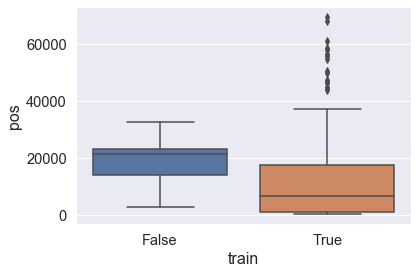

In [11]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

#### First wave

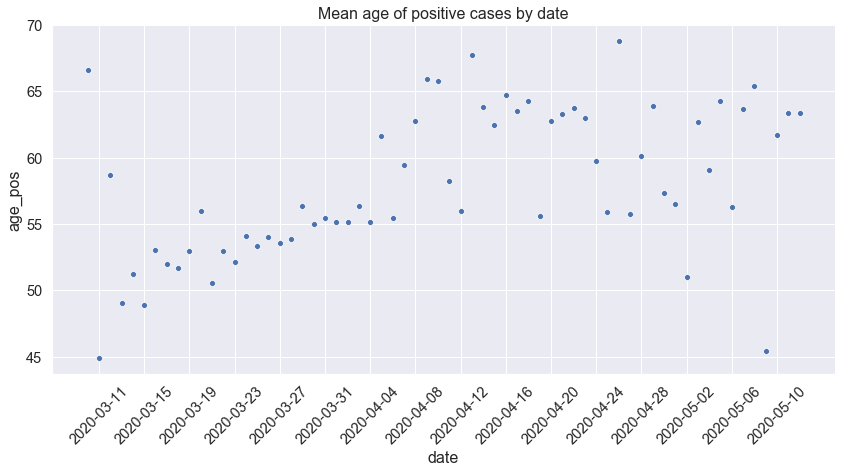

In [12]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr_old, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr_old["date"].min(), 
                    df_feat_fr_old["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

#### Second wave

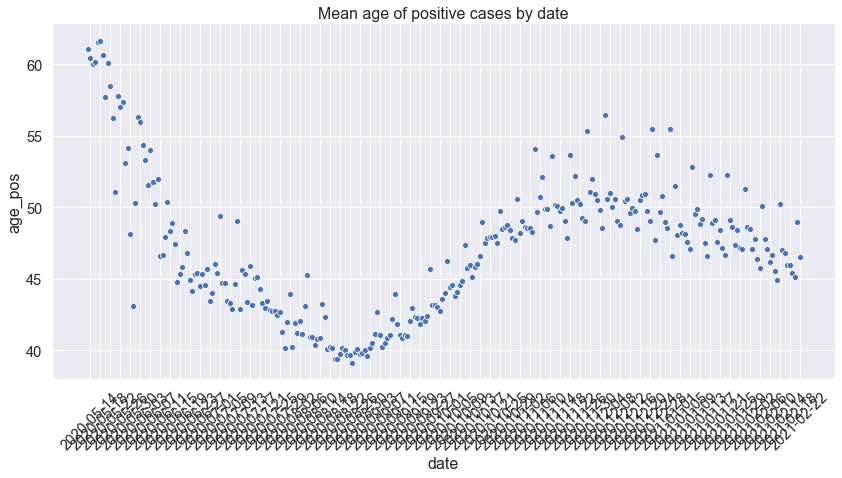

In [13]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

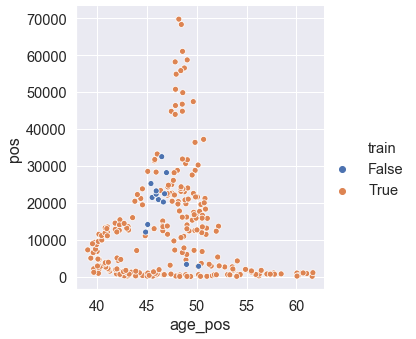

In [14]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

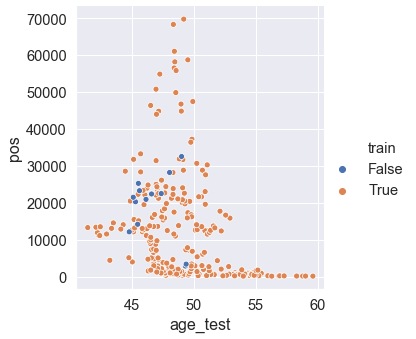

In [15]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

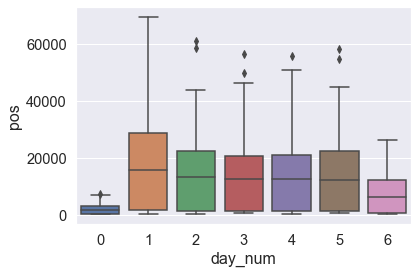

In [16]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [17]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

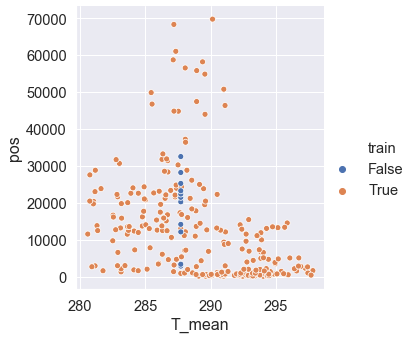

In [18]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

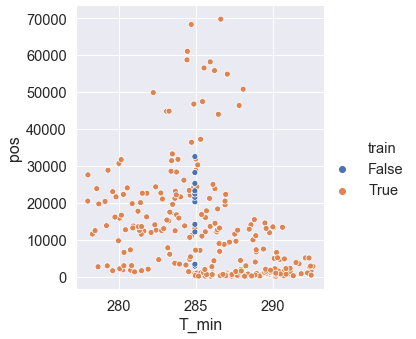

In [19]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

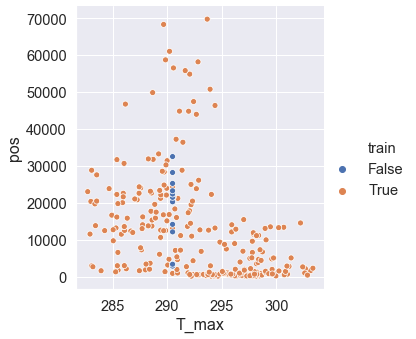

In [20]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

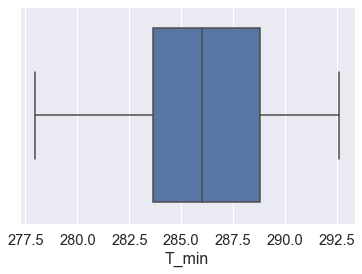

In [21]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [22]:
df_feat_fr["T_min"].mean()

285.9304207957904

In [23]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

False    144
True     142
Name: T_min, dtype: int64

In [24]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

True     143
False    143
Name: T_min, dtype: int64

In [25]:
df_feat_fr["T_min"].median()

285.99588983050853

In [26]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

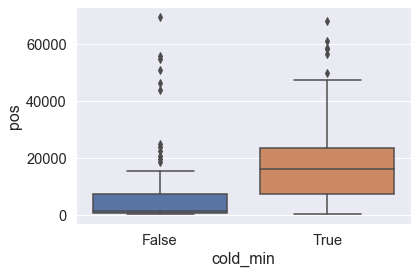

In [27]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then more positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

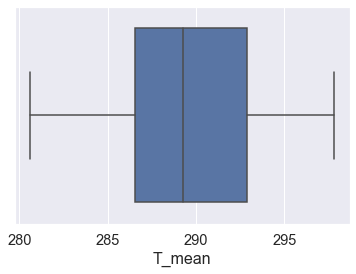

In [28]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [29]:
df_feat_fr["T_mean"].median()

289.2518785310735

In [30]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

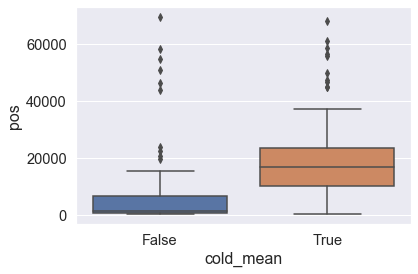

In [31]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

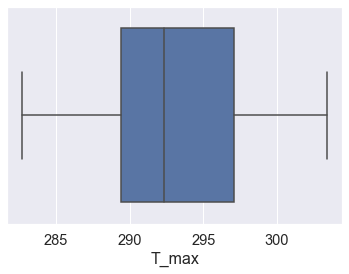

In [32]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [33]:
df_feat_fr["T_max"].median()

292.3584745762712

In [34]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

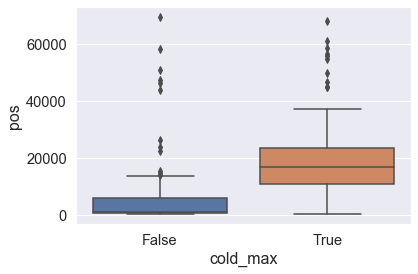

In [35]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [36]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

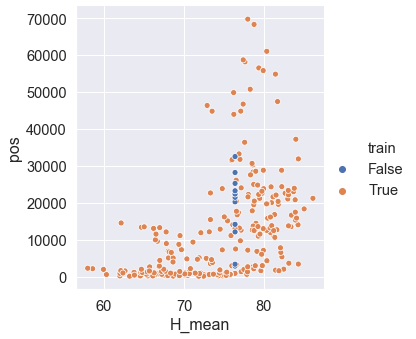

In [37]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

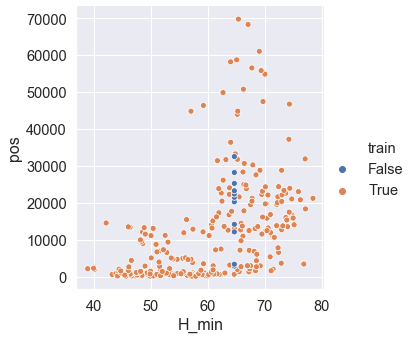

In [38]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

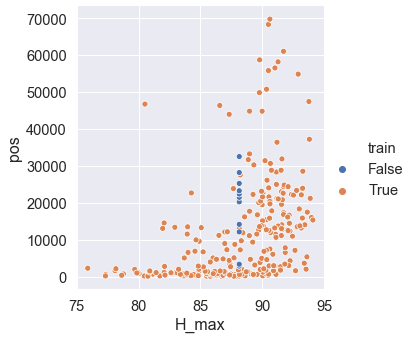

In [39]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

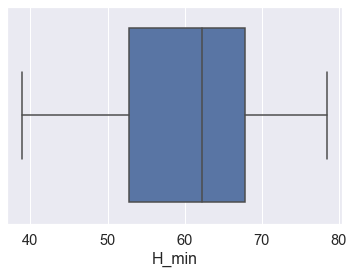

In [40]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [41]:
df_feat_fr["H_min"].median()

62.288135593220346

In [42]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

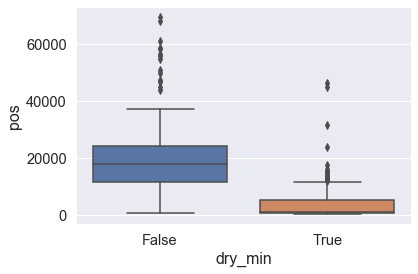

In [43]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> more DRY, less positive cases

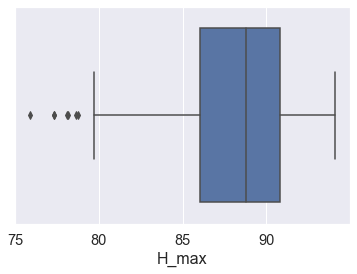

In [44]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [45]:
df_feat_fr["H_max"].median()

88.76379310344828

In [46]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

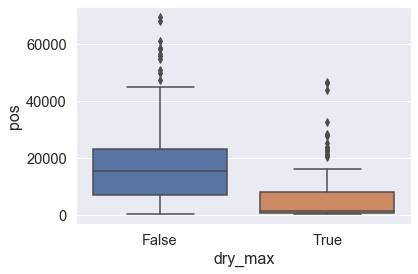

In [47]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> => Same than H min

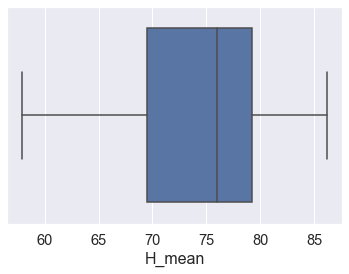

In [48]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [49]:
df_feat_fr["H_mean"].median()

76.0081896551724

In [50]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

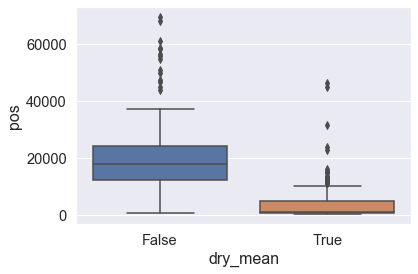

In [51]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Same H min

### Seasonality impact

In [52]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

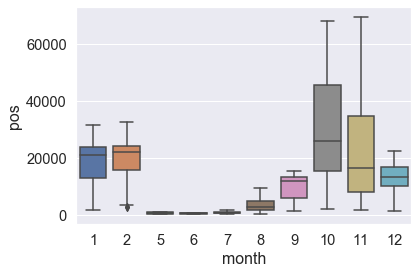

In [53]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

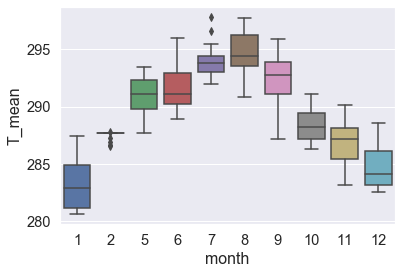

In [54]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

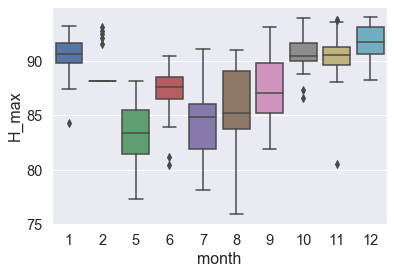

In [55]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [56]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
1      558829
2      439587
5       11842
6       14892
7       24762
8      105833
9      293344
10     932646
11     671110
12     395860

### Nb Tested

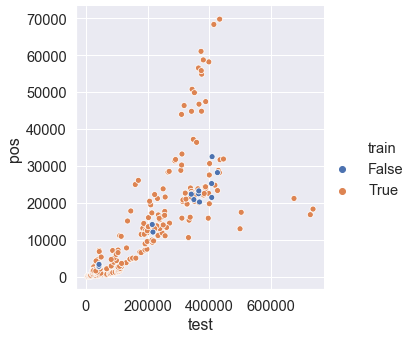

In [57]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [58]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [59]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=100*df_feat_fr_old["pos"] / df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [9]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [10]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max    pos    test  \
date                                                                      
2020-05-13  284.926667  290.505000  64.661017  88.135593    881   39048   
2020-05-14  285.050000  290.963333  59.406780  84.847458    979   41986   
2020-05-15  285.308333  291.920000  57.372881  82.966102   1021   47686   
2020-05-16  284.956667  293.500000  53.741379  86.534483    291   16535   
2020-05-17  285.598333  294.446667  49.879310  85.500000    139    6604   
...                ...         ...        ...        ...    ...     ...   
2021-02-18  284.926667  290.505000  64.661017  88.135593  23249  365658   
2021-02-19  284.926667  290.505000  64.661017  88.135593  25239  407099   
2021-02-20  284.926667  290.505000  64.661017  88.135593  14158  215229   
2021-02-21  284.926667  290.505000  64.661017  88.135593   3361   43302   
2021-02-22  284.926667  290.505000  64.661017  88.135593  32516  408561   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  61.023837  55.435003  
2020-05-14        4  60.426966  54.831611  
2020-05-15        5  60.042116  54.385124  
2020-05-16        6  60.158076  54.486302  
2020-05-17        0  61.568345  58.291036  
...             ...        ...        ...  
2021-02-18        4  45.952772  45.595477  
2021-02-19        5  45.428226  45.506624  
2021-02-20        6  45.102698  45.446264  
2021-02-21        0  48.987504  49.366357  
2021-02-22        1  46.509718  48.996314  

[286 rows x 9 columns]

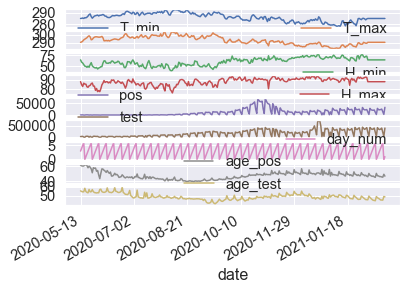

In [11]:
features.plot(subplots=True);

In [12]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [13]:
dataset.shape

(286, 9)

## Multi-step model

### Helper functions

In [14]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [15]:
TRAIN_SPLIT

272

In [16]:
dataset.shape

(286, 9)

In [17]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [18]:
y_train_multi.shape

(258, 7)

In [19]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target future to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

258 Single window of past history : (14, 9)

 258 Target future to predict : (7,)


In [20]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 258
BUFFER_SIZE : 272

For validation : 
BATCH_SIZE_VAL : 7


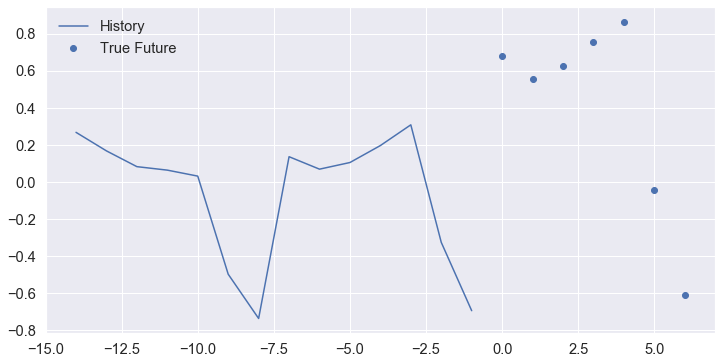

In [72]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [73]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 258
nb samples for validation : 7


In [74]:
x_train_multi.shape[-2:]

(14, 9)

In [75]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model

from tcn import TCN, tcn_full_summary

batch_size, timesteps, input_dim = None, 20, 1


def get_x_y(size=1000):
    import numpy as np
    pos_indices = np.random.choice(size, size=int(size // 2), replace=False)
    x_train = np.zeros(shape=(size, timesteps, 1))
    y_train = np.zeros(shape=(size, 1))
    x_train[pos_indices, 0] = 1.0
    y_train[pos_indices, 0] = 1.0
    return x_train, y_train


i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        dilations = [1, 2, 4])(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse')

tcn_full_summary(m, expand_residual_blocks=False)

x, y = get_x_y()
m.fit(x, y, epochs=10, validation_split=0.2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl [(None, 20, 64), (None, 2 8576      
_________________________________________________________________
residual_block_1 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
residual_block_2 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
lambda (Lambda)              (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________

In [76]:
tcn_full_summary(m, expand_residual_blocks=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 20, 64)            128       
_________________________________________________________________
activation_3 (Activation)    (None, 20, 64)            0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 20, 64)            192       
_________________________________________________________________
activation (Activation)      (None, 20, 64)            0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 64)            0         
_________________________________________________________________
conv1D_1 (Conv1D)            (None, 20, 64)            8256  

In [77]:



lr = 2e-2
decay = 1e-6 #1e-6
momentum = 0.9 # 0.9
nesterov = True # True
patience = 250 # 30

sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

out_tcn = TCN(return_sequences=False,
        dilations = [1, 2, 4])(in_tcn)  # The TCN layers are here.
out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)

multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
multi_step_model.compile(optimizer=sgd_2, loss='mae')

tcn_full_summary(multi_step_model, expand_residual_blocks=False)


'''# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(Conv1D(filters=1, 
                            kernel_size=2, 
                            padding='causal',
                            dilation_rate=2, 
                            activation=None,
                            input_shape=x_train_multi.shape[-2:],
                        kernel_initializer=tf.keras.initializers.Constant(1.),
                           use_bias=False))'''

#x = Conv1D(filters, kernel_size, strides=1, padding='causal', data_format='channels_last',
#    dilation_rate=1, groups=1, activation=None)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl [(None, 20, 64), (None, 2 8576      
_________________________________________________________________
residual_block_1 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
residual_block_2 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
lambda_1 (Lambda)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 42,055
Trainable params: 42,055
Non-trainable params: 0
_______________________________________________________

"# create model\nmulti_step_model = tf.keras.models.Sequential()\nmulti_step_model.add(Conv1D(filters=1, \n                            kernel_size=2, \n                            padding='causal',\n                            dilation_rate=2, \n                            activation=None,\n                            input_shape=x_train_multi.shape[-2:],\n                        kernel_initializer=tf.keras.initializers.Constant(1.),\n                           use_bias=False))"


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00454: early stopping
Run #0 : val_loss = 0.20916536450386047


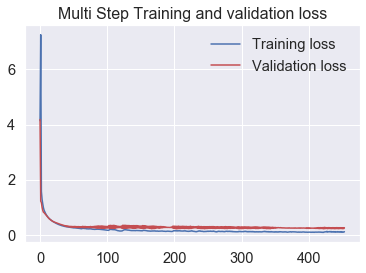

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00506: early stopping
Run #1 : val_loss = 0.2066114991903305


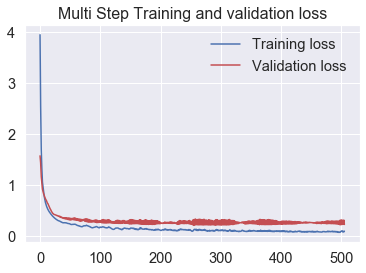

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00429: early stopping
Run #2 : val_loss = 0.16177012026309967


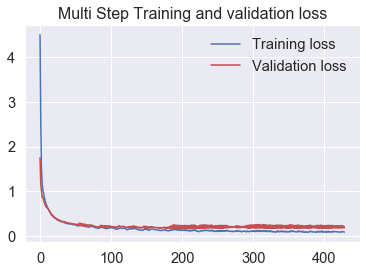

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00531: early stopping
Run #3 : val_loss = 0.1532241255044937


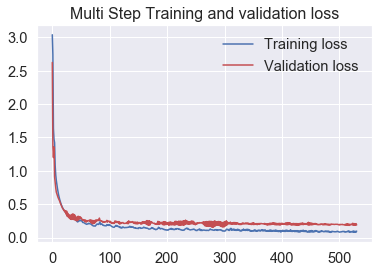

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00457: early stopping
Run #4 : val_loss = 0.24420574307441711

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00656: early stopping
Run #5 : val_loss = 0.17926587164402008

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00474: early stopping
Run #6 : val_loss = 0.14352774620056152


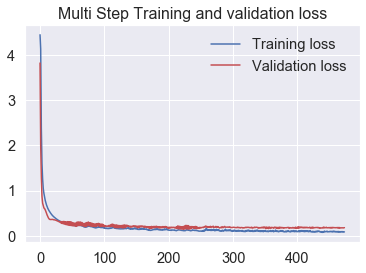

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01170: early stopping
Run #7 : val_loss = 0.1708509474992752

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00905: early stopping
Run #8 : val_loss = 0.22723719477653503

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00304: early stopping
Run #9 : val_loss = 0.2002524584531784

 Run #10
Restoring model weights from the end of the best epoch.
Epoch 00615: early stopping
Run #10 : val_loss = 0.19982969760894775

 Run #11
Restoring model weights from the end of the best epoch.
Epoch 00460: early stopping
Run #11 : val_loss = 0.20434065163135529

 Run #12
Restoring model weights from the end of the best epoch.
Epoch 00710: early stopping
Run #12 : val_loss = 0.2425340861082077

 Run #13
Restoring model weights from the end of the best epoch.
Epoch 01164: early stopping
Run #13 : val_loss = 0.167732983827

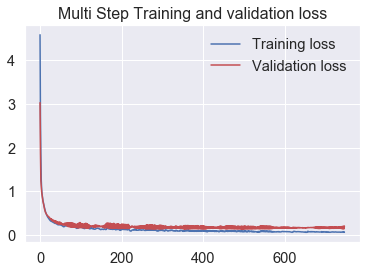

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets

 Run #28
Restoring model weights from the end of the best epoch.
Epoch 00421: early stopping
Run #28 : val_loss = 0.21211834251880646

 Run #29
Restoring model weights from the end of the best epoch.
Epoch 00620: early stopping
Run #29 : val_loss = 0.2198341190814972

 Run #30
Restoring model weights from the end of the best epoch.
Epoch 00444: early stopping
Run #30 : val_loss = 0.21877241134643555

 Run #31
Restoring model weights from the end of the best epoch.
Epoch 00463: early stopping
Run #31 : val_loss = 0.2545120120048523

 Run #32
Restoring model weights from the end of the best epoch.
Epoch 00661: early stopping
Run #32 : val_loss = 0.2392890751361847

 Run #33
Restoring model weights from the end of the best epoch.
Epoch 00772: early stopping
Run #33 : val_loss = 0.1853204071521759

 Run #34
Restoring model weights from the end of the best epoch.
Epoch 00370: early stopping
Run #34 : val_loss = 0.2142497

Restoring model weights from the end of the best epoch.
Epoch 00475: early stopping
Run #89 : val_loss = 0.21061977744102478

 Run #90
Restoring model weights from the end of the best epoch.
Epoch 00789: early stopping
Run #90 : val_loss = 0.193072110414505

 Run #91
Restoring model weights from the end of the best epoch.
Epoch 00713: early stopping
Run #91 : val_loss = 0.20596876740455627

 Run #92
Restoring model weights from the end of the best epoch.
Epoch 00801: early stopping
Run #92 : val_loss = 0.16564372181892395

 Run #93
Restoring model weights from the end of the best epoch.
Epoch 02093: early stopping
Run #93 : val_loss = 0.2022283375263214

 Run #94
Restoring model weights from the end of the best epoch.
Epoch 01756: early stopping
Run #94 : val_loss = 0.1790003478527069

 Run #95
Restoring model weights from the end of the best epoch.
Epoch 01008: early stopping
Run #95 : val_loss = 0.16560150682926178

 Run #96
Restoring model weights from the end of the best epoch.
Epo

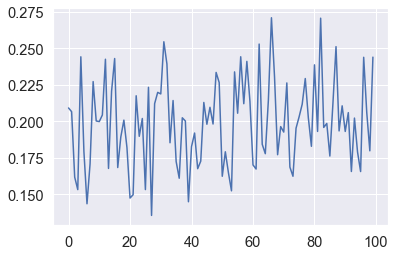

In [78]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    NB_TRY = 100 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000

    # Hyper-parameters
    # lr=6e-2, decay = 1e-6, momentum = 0.9,  nesterov = True, patience = 250
    # Final val_loss = 0.18278686702251434
    # Mean asbolute Error in people : 2587.2852865276022
    # Mac : CPU times: user 1h 50min 6s, sys: 43min 33s, total: 2h 33min 39s
    # Mac : Wall time: 1h 22min 11s
    
    lr = 2e-2
    decay = 1e-6 #1e-6
    momentum = 0.9 # 0.9
    nesterov = True # True
    patience = 250 # 30

    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(return_sequences=False,
            dilations = [1, 2, 4])(in_tcn)  # The TCN layers are here.
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)

        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        
        '''multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))'''
        # compile
        multi_step_model.compile(optimizer=sgd_2, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


### Eval

In [21]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr_tcn'

In [22]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

CPU times: user 1.62 s, sys: 99.8 ms, total: 1.72 s
Wall time: 1.84 s


In [23]:
%%time
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)
print("Mean error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Mean nb cases  [nb of cases]: ", mean_val)
print("mean relative error [%]: ", 100*mean_error_val/mean_val)

Mean error  [nb of cases]:  1901.908034710237
Mean nb cases  [nb of cases]:  19043.061224489797
mean relative error [%]:  9.987407026052834
CPU times: user 239 ms, sys: 16.2 ms, total: 255 ms
Wall time: 280 ms


In [24]:
multi_step_model.predict(x_val_multi)

array([[ 1.1321887 ,  0.49588165,  1.1443073 ,  0.78329504,  0.05576786,
        -0.7208046 ,  1.5633714 ],
       [ 0.608137  ,  0.4895377 ,  0.8389456 ,  0.10043043, -0.66547096,
         0.95068264,  0.72346747],
       [ 0.51970947,  0.5577182 ,  0.0127893 , -0.8440008 ,  1.0865332 ,
         0.8304032 ,  0.71910197],
       [ 0.20498225,  0.20316468, -0.6250949 ,  1.3007079 ,  0.6841934 ,
         0.78849626,  0.6465525 ],
       [-0.08827239, -0.56322473,  1.0828971 ,  0.7278613 ,  0.7545727 ,
         0.9921638 ,  0.90065926],
       [-0.8416    ,  1.0762702 ,  0.49931037,  0.8438436 ,  0.9757434 ,
         0.95648193,  0.11881533],
       [ 1.1766025 ,  1.0051991 ,  1.0529656 ,  0.5628687 ,  0.8635438 ,
         0.38753298, -0.57156736]], dtype=float32)

In [25]:
y_val_multi_pred.shape[0]

7

In [84]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

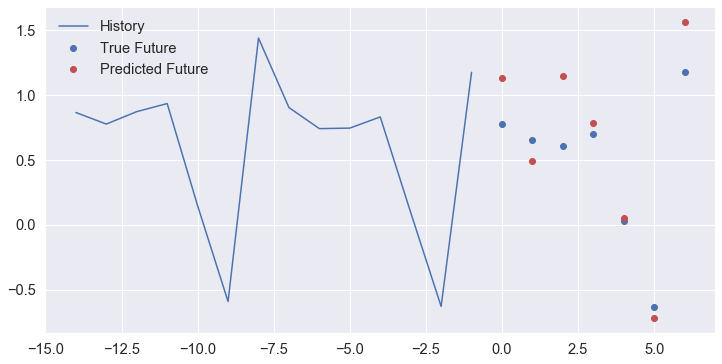

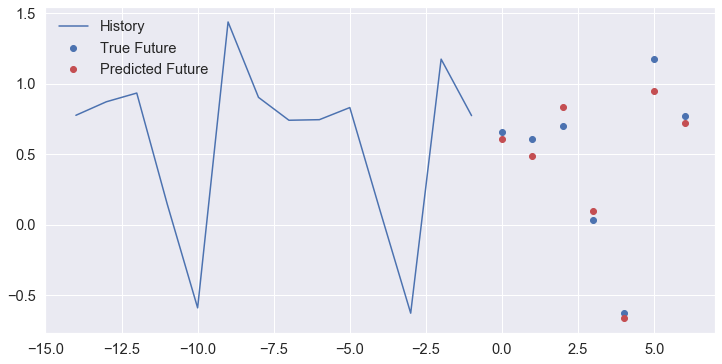

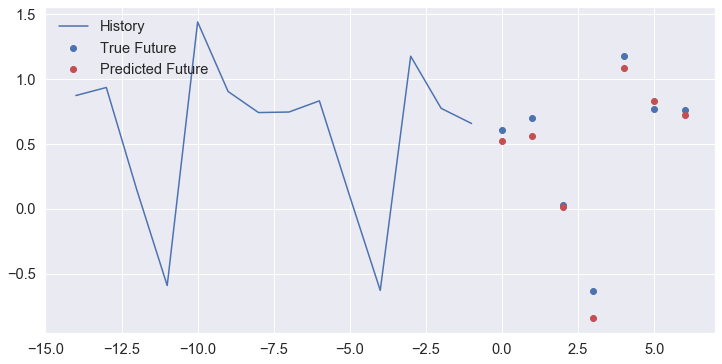

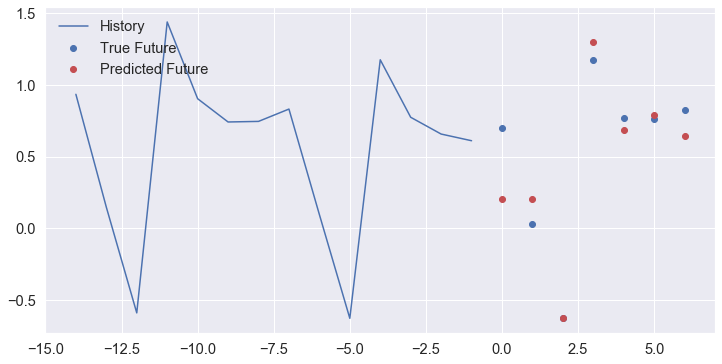

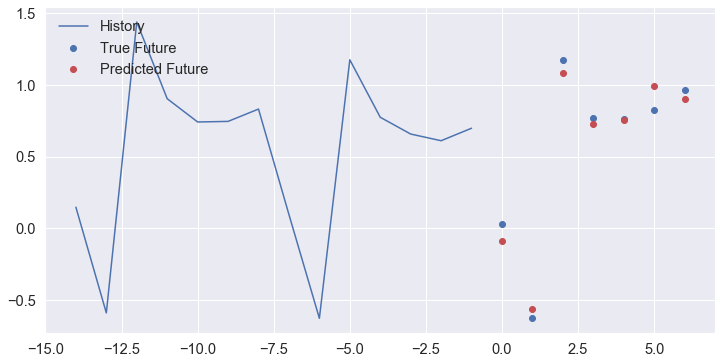

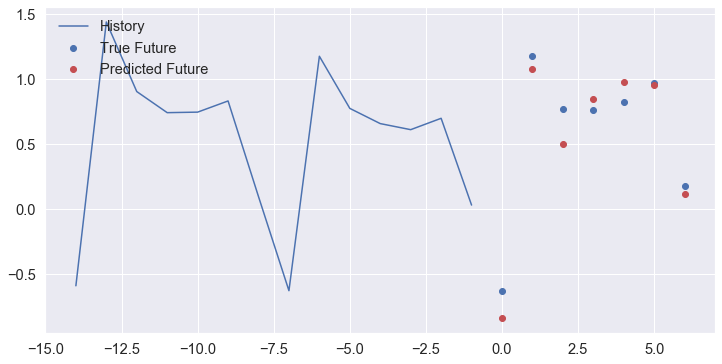

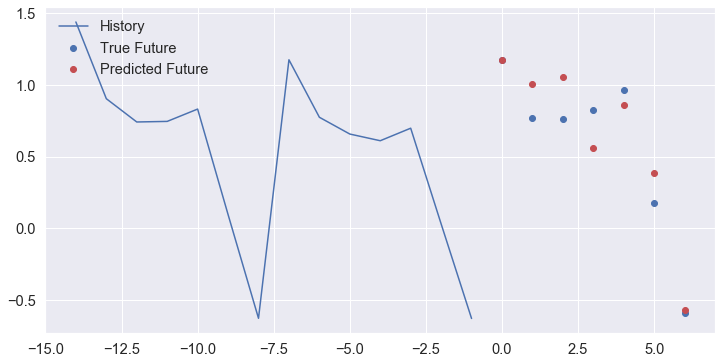

In [85]:
for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [26]:
nb_period_plot = 23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [27]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr_tcn'

In [28]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

In [29]:
TRAIN_SPLIT

272

In [30]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [31]:
df_feat_fr.shape

(286, 15)

In [32]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 193 ms, sys: 10.3 ms, total: 203 ms
Wall time: 235 ms


In [33]:
df_feat_fr.date.min()

'2020-05-13'

In [34]:
df_feat_fr.date.max()

'2021-02-22'

In [35]:
df_feat_fr.pos.std()

13928.265368646085

In [36]:
data_std[4]

14031.04644324443

In [37]:
str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
str_date_0

'2020-09-14'

In [38]:
# last nth days
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date    pos  nb_cases
2021-02-23  2021-02-23  28253   3617185
2021-02-24  2021-02-24  22466   3639651
2021-02-25  2021-02-25  24976   3664627
2021-02-26  2021-02-26  25719   3690346
2021-02-27  2021-02-27  12470   3702816
2021-02-28  2021-02-28   1126   3703942
2021-03-01  2021-03-01  34218   3738160

In [39]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2021-02-09'

In [40]:
df_plot

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-09-14  289.485000  2020-09-14  302.236667  42.203390  82.067797     0.0   
2020-09-15  290.628333  2020-09-15  300.703333  46.406780  82.932203     0.0   
2020-09-16  290.060000  2020-09-16  300.238333  48.864407  85.067797     0.0   
2020-09-17  290.000847  2020-09-17  299.477119  46.086207  83.965517     0.0   
2020-09-18  289.563333  2020-09-18  298.991667  50.440678  81.949153     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-02-18  284.926667  2021-02-18  290.505000  64.661017  88.135593     1.0   
2021-02-19  284.926667  2021-02-19  290.505000  64.661017  88.135593     1.0   
2021-02-20  284.926667  2021-02-20  290.505000  64.661017  88.135593     1.0   
2021-02-21  284.926667  2021-02-21  290.505000  64.661017  88.135593     1.0   
2021-02-22  284.926667  2021-02-22  290.505000  64.661017  88.135593     1.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-09-14  14528  41.836798  271092  43.485599        1    418370   120814.0   
2020-09-15  13365  41.060157  261637  42.073422        2    431735   125441.0   
2020-09-16  13263  40.844454  243206  41.414332        3    444998   129749.0   
2020-09-17  13484  41.084248  239530  42.431762        4    458482   133654.0   
2020-09-18  13058  41.011717  239689  43.338630        5    471540   136754.0   
...           ...        ...     ...        ...      ...       ...        ...   
2021-02-18  23249  45.952772  365658  45.595477        4   3513658   263845.0   
2021-02-19  25239  45.428226  407099  45.506624        5   3538897   265734.0   
2021-02-20  14158  45.102698  215229  45.446264        6   3553055   266867.0   
2021-02-21   3361  48.987504   43302  49.366357        0   3556416   267357.0   
2021-02-22  32516  46.509718  408561  48.996314        1   3588932   271700.0   

                  Rt  rate_pos  
date                            
2020-09-14  1.698997  5.359066  
2020-09-15  1.669097  5.108222  
2020-09-16  1.635952  5.453402  
2020-09-17  1.594403  5.629357  
2020-09-18  1.541168  5.447893  
...              ...       ...  
2021-02-18  0.924925  6.358127  
2021-02-19  0.934712  6.199720  
2021-02-20  0.940467  6.578110  
2021-02-21  0.942490  7.761766  
2021-02-22  0.969793  7.958665  

[162 rows x 15 columns]

### Figure

In [41]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [42]:
nb_period_plot

23

In [43]:
dataset.shape

(286, 9)

In [44]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[111 - 125]
[118 - 132]
[125 - 139]
[132 - 146]
[139 - 153]
[146 - 160]
[153 - 167]
[160 - 174]
[167 - 181]
[174 - 188]
[181 - 195]
[188 - 202]
[195 - 209]
[202 - 216]
[209 - 223]
[216 - 230]
[223 - 237]
[230 - 244]
[237 - 251]
[244 - 258]
[251 - 265]
[258 - 272]
[265 - 279]
23
CPU times: user 1.28 s, sys: 101 ms, total: 1.39 s
Wall time: 1.78 s


array([[13607.374 , 14958.299 , 15771.357 , 15536.51  ,  6014.352 ,
         2734.46  , 18280.922 , 14619.098 , 14238.24  , 14015.532 ,
        12355.455 ,  6387.9907,  1660.4336, 15236.433 , 13324.055 ,
        14020.017 , 14710.654 , 16673.844 ,  7547.775 ,  2308.665 ,
        22030.143 , 19482.65  , 21526.71  , 22649.594 , 23833.947 ,
        11421.319 ,  4031.248 , 31927.793 , 30006.027 , 30829.695 ,
        31970.355 , 34915.113 , 15641.974 ,  4134.8306, 45624.023 ,
        46670.79  , 46284.836 , 51879.45  , 54799.465 , 26553.082 ,
         8792.139 , 68381.07  , 61711.383 , 56385.273 , 57953.355 ,
        58300.45  , 26565.746 ,  8019.965 , 70205.34  , 60650.25  ,
        49870.08  , 50931.715 , 48450.516 , 19458.963 ,  6542.207 ,
        52915.777 , 37947.77  ,  8051.8364, 36730.39  , 30265.059 ,
        13059.534 ,  4204.499 , 32516.117 , 22218.473 , 17762.021 ,
        18284.441 , 16901.504 ,  8503.254 ,  1611.3926, 19076.803 ,
        14544.031 , 14291.668 , 13653.158 , 1281

In [45]:
y_pos_pred.shape

(1, 161)

In [46]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

161
2020-09-14
2021-02-22


date    pos  nb_cases
2020-09-15  2020-09-15  13607    431977
2020-09-16  2020-09-16  14958    446935
2020-09-17  2020-09-17  15771    462706
2020-09-18  2020-09-18  15536    478242
2020-09-19  2020-09-19   6014    484256
...                ...    ...       ...
2021-02-18  2021-02-18  22010   3513076
2021-02-19  2021-02-19  21153   3534229
2021-02-20  2021-02-20  10770   3544999
2021-02-21  2021-02-21   2435   3547434
2021-02-22  2021-02-22  30202   3577636

[161 rows x 3 columns]

### Figure all past 

In [47]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [48]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [49]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()